In [2]:
import sys
sys.path.append("/home/hugo/projetos-doutorado/Appliance-Energy-Prediction")
import pandas as pd
from pca_fts.PcaSarimax import PcaSarimax
from pyFTS.benchmarks import Measures
import matplotlib.pyplot as plt
from pyFTS.common import Util
import datetime
import statistics
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [3]:
def sample_first_prows(data, perc=0.75):
    return data.head(int(len(data)*(perc)))

In [4]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

## Dataset Household Power Consumption

In [6]:
filepath = '/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/household_power_consumption.csv'
data = pd.read_csv(filepath, sep = ";")
data = data.drop(labels=['Time','Date'], axis=1)
data = data.loc[0: : 30] # 30 minutes
data.dropna(inplace = True)
data = clean_dataset(data)
data.head()

/home/hugo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0
30,2.720,0.000,235.06,11.6,0.0,0.0,17.0
60,3.452,0.000,235.20,15.2,0.0,1.0,17.0
90,4.298,0.000,232.39,18.4,0.0,1.0,16.0
120,3.262,0.052,232.64,14.0,0.0,0.0,17.0


## Dataset Household Power Consumption, Lag = 1, t+1

In [7]:
data = series_to_supervised_miso(data, 1, 1,endog_var='Global_active_power')
data.head()

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_1(t-1),Sub_metering_2(t-1),Sub_metering_3(t-1),Global_active_power(t)
30,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2.720
60,2.720,0.000,235.06,11.6,0.0,0.0,17.0,3.452
90,3.452,0.000,235.20,15.2,0.0,1.0,17.0,4.298
120,4.298,0.000,232.39,18.4,0.0,1.0,16.0,3.262
150,3.262,0.052,232.64,14.0,0.0,0.0,17.0,3.214


## Model: PcaSarimax - PCA-SARIMAX

### Define SARIMAX parameters 

In [8]:
pca_sarimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'Global_active_power(t-1)',
                       order = [0, 0, 0],
                       seasonal_order = [0,0,0,0])

In [9]:
df_train = data.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
train = sample_first_prows(data, perc=0.30)

In [10]:
reduced = pca_sarimax.apply_pca(train)
reduced.head(2)

,C0,C1,Global_active_power(t-1)
0,0.651087,0.191734,4.216
1,0.633207,0.144267,2.720


In [11]:
exog = reduced.drop(labels=['Global_active_power(t-1)'], axis=1)
exog.head(2)

,C0,C1
0,0.651087,0.191734
1,0.633207,0.144267


In [12]:
endog = reduced['Global_active_power(t-1)']
endog.head(3)

0    4.216
1    2.720
2    3.452
Name: Global_active_power(t-1), dtype: float64

In [13]:
train_y = endog
train_X = exog

In [14]:
# Define arimax paraters using the embedded data 
# from pmdarima.arima import auto_arima
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf',
#                        start_p=0,
#                        start_q=0,
#                        max_p=5,
#                        max_q=5,
#                        start_Q=0,
#                        start_P=0,
#                        max_P=5,
#                        max_Q=5,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        max_D=5,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)
# #                        n_fits = 50)

In [15]:
#  ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=40774.955, Time=6.39 sec
#  ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=33919.774, Time=26.49 sec
#  ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=57.71 sec
#  ARIMA(0,0,0)(0,1,0)[7]             : AIC=40772.955, Time=11.11 sec
#  ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=39425.191, Time=7.92 sec
#  ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=32398.909, Time=46.83 sec
#  ARIMA(1,0,0)(3,1,0)[7] intercept   : AIC=31218.484, Time=64.64 sec
#  ARIMA(1,0,0)(4,1,0)[7] intercept   : AIC=30213.416, Time=96.16 sec
#  ARIMA(1,0,0)(5,1,0)[7] intercept   : AIC=29495.805, Time=161.14 sec

### Test the model with the best parameters 

In [16]:
# pca_arimax = PcaSarimax(n_components = 2,
#                        endogen_variable = 'Global_active_power(t-1)',
#                        order=[4,0,0],
#                        seasonal_order=[5,1,0,7])

In [26]:
# df_train = data.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
# df_test = data.loc[:,'Global_reactive_power(t-1)':'Global_active_power(t)']
# train = sample_first_prows(df_train,0.75)
# test = df_test.iloc[max(train.index):]

In [9]:
# model, sarimax, pca_reduced_train = pca_arimax.run_train_model(train)

In [10]:
# sarimax.summary()

In [11]:
# pca_reduced_train.head(2)

In [12]:
#ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
# test.rename(columns = {'use [kW](t)': 'use [kW](t-1)'}, inplace = True)
# start = len(train)
# end = len(train) + len(test) -1
# forecast, pca_reduced_test = pca_arimax.run_test_model(test, sarimax,start,end)

In [13]:
# forecast

In [14]:
#pca_reduced_test['Appliances(t-1)'].head(2)
# pca_reduced_test.head(5)

In [15]:
# print(Measures.rmse(pca_reduced_test['use [kW](t-1)'],forecast))
# print(Measures.mape(pca_reduced_test['use [kW](t-1)'],forecast))

## Model: PcaSarimax - PCA-SARIMAX - Final model 

In [41]:
# ARIMA(1,0,0)(5,1,0)[7] ==> 0.901978	0.519373	65.378872	23.312508 
# ARIMA(1,0,0)(1,1,0)[7] ==> 0.901978	0.519373	65.378872	23.312508
# ARIMA(1,0,1)(1,1,1)[7] ==> 0.901098	0.517399	64.944311	22.93125
# ARIMA(1,0,0)(1,1,1)[7] ==> 0.901256	0.517574	64.99313	22.962299
# ARIMA(1,0,1)(1,1,0)[7] ==> 0.901879	0.519276	65.342213	23.30976
# ARIMA(1,0,1)(2,1,0)[7]==> 0.901052	0.517548	64.931938	22.989602

In [48]:
pca_sarimax = PcaSarimax(n_components = 2,
                       endogen_variable = 'Global_active_power(t-1)',
                       order=[1,0,1],
                       seasonal_order=[2,1,1,7])

## Sliding Window PyFTS: PCA-SARIMAX

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:23:51] getting statistics


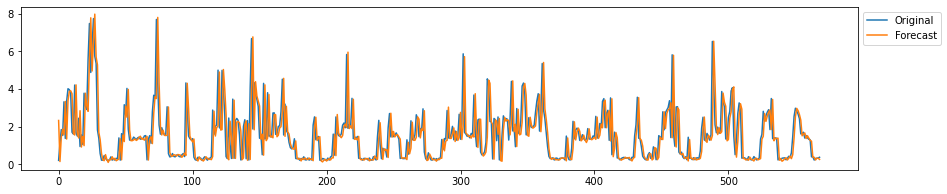

--------------------
training window 2276


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:24:21] getting statistics


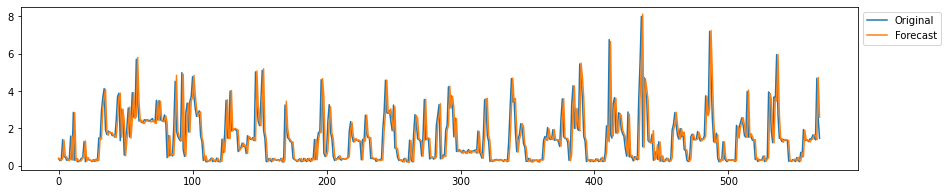

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 4552


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:24:51] getting statistics


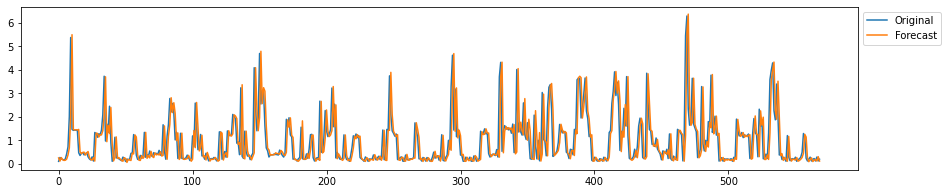

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 6828


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:25:22] getting statistics


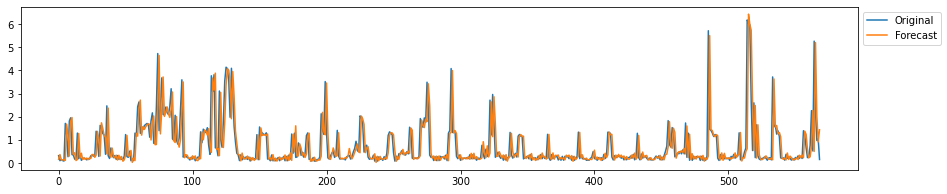

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 9104


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:25:54] getting statistics


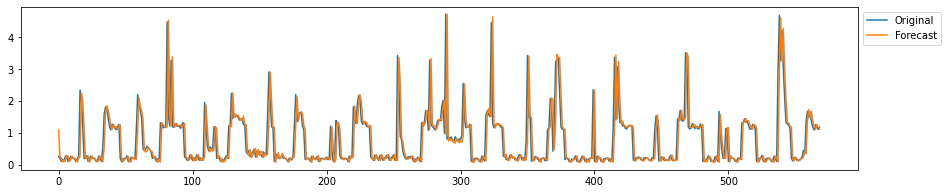

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 11380


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:26:23] getting statistics


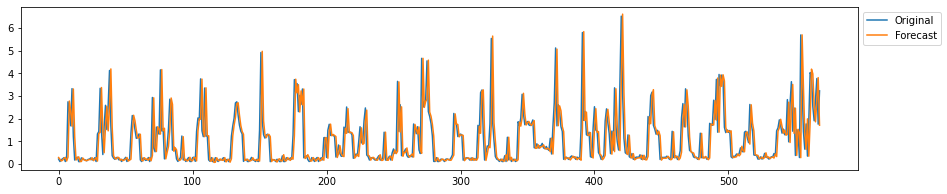

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 13656


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:26:51] getting statistics


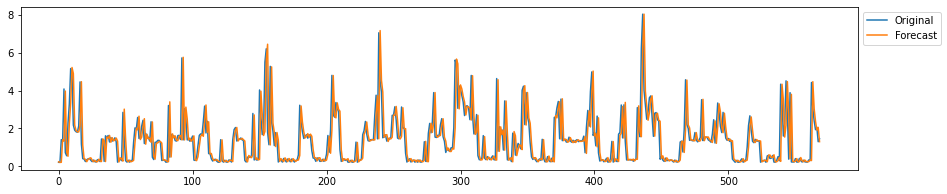

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 15932


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:27:20] getting statistics


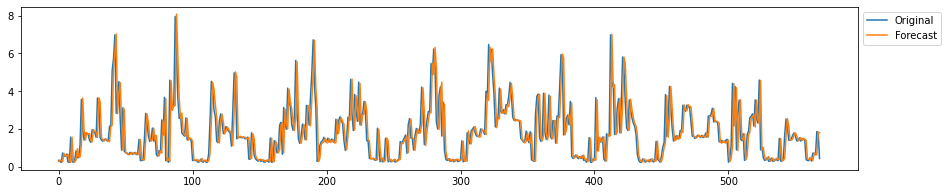

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 18208


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:27:49] getting statistics


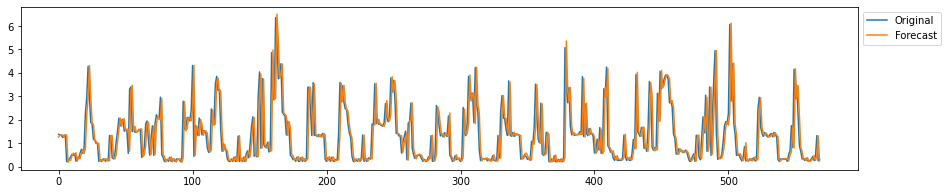

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 20484


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:28:13] getting statistics


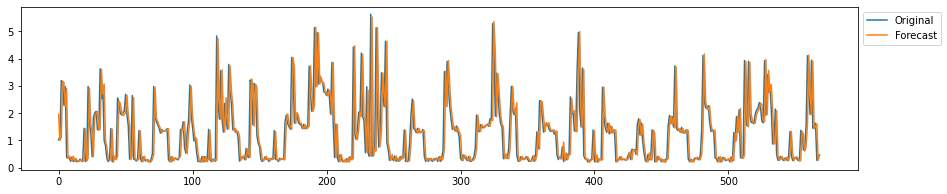

--------------------
training window 22760


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:28:35] getting statistics


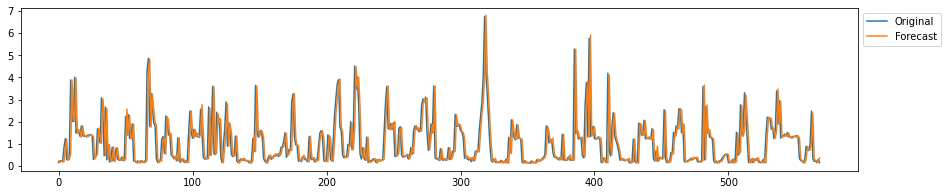

--------------------
training window 25036


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:28:56] getting statistics


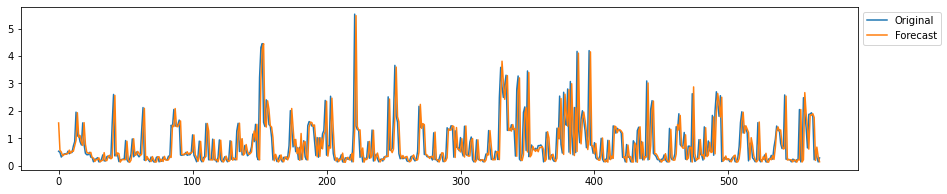

--------------------
training window 27312


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:29:19] getting statistics


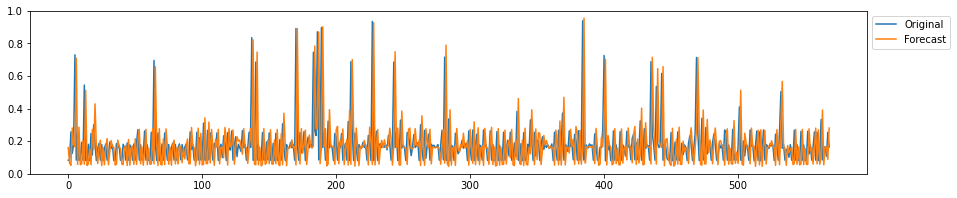

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 29588


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:29:41] getting statistics


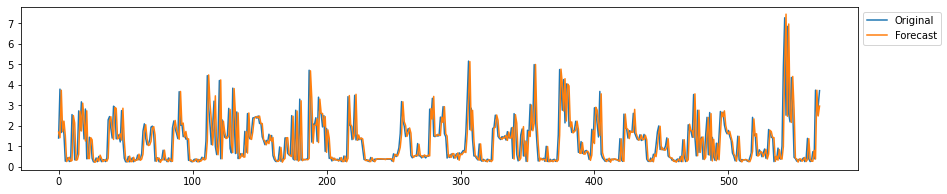

--------------------
training window 31864


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:30:03] getting statistics


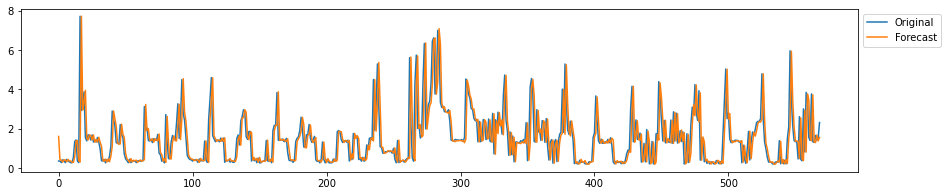

--------------------
training window 34140


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:30:24] getting statistics


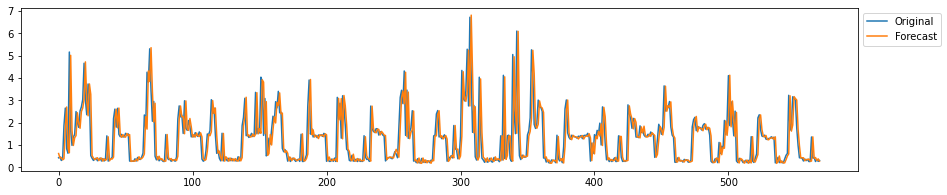

--------------------
training window 36416


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:30:48] getting statistics


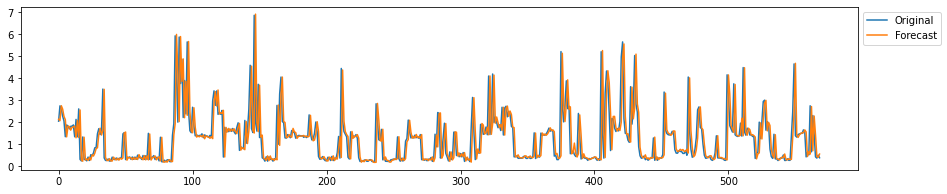

--------------------
training window 38692


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:31:11] getting statistics


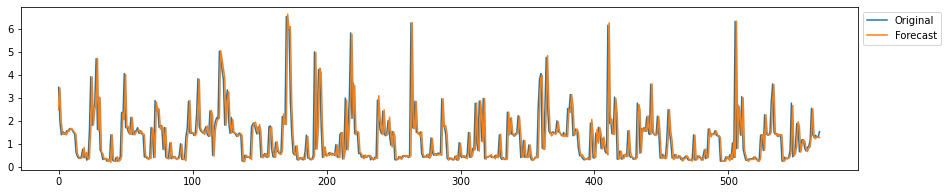

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 40968


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:31:34] getting statistics


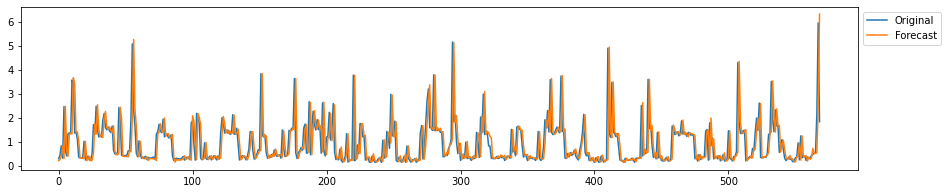

--------------------
training window 43244


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:31:55] getting statistics


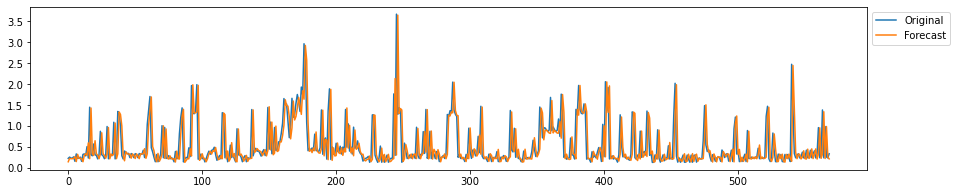

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 45520


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:32:18] getting statistics


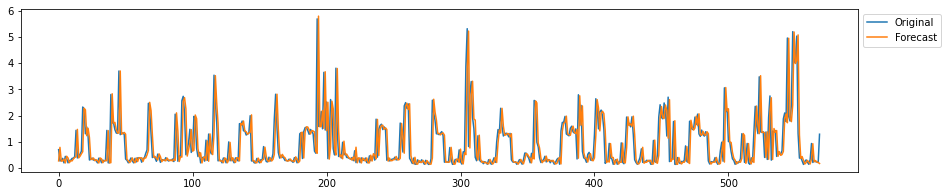

--------------------
training window 47796


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:32:40] getting statistics


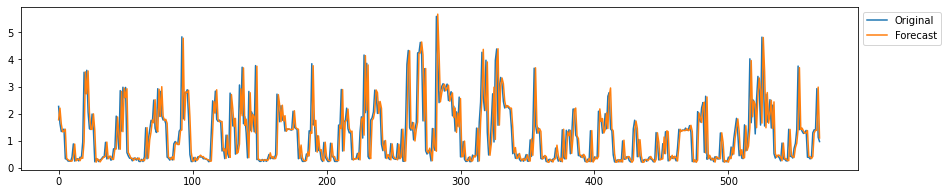

--------------------
training window 50072


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:33:01] getting statistics


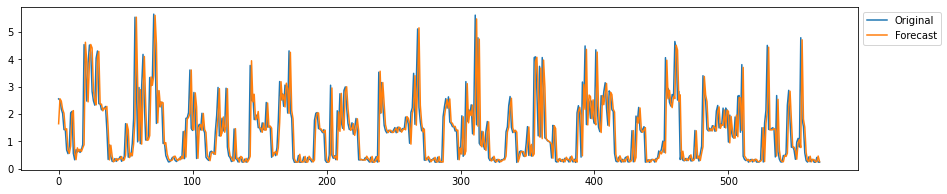

/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


--------------------
training window 52348


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:33:23] getting statistics


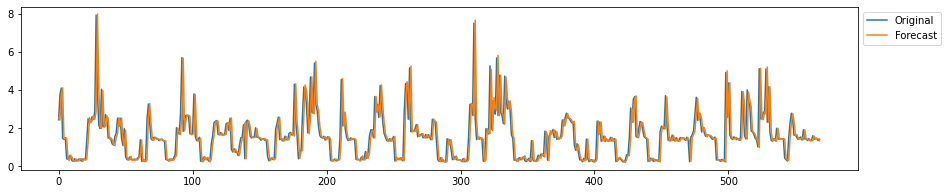

--------------------
training window 54624


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:33:47] getting statistics


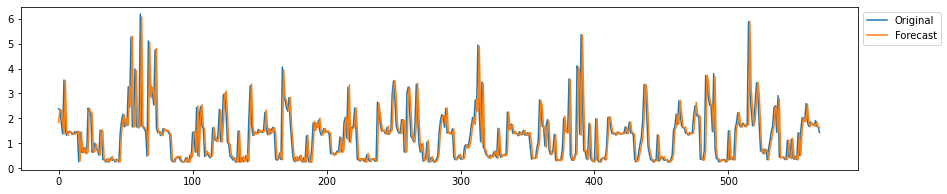

--------------------
training window 56900


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:34:08] getting statistics


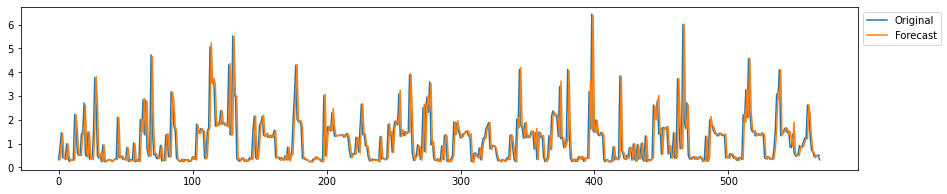

--------------------
training window 59176


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:34:33] getting statistics


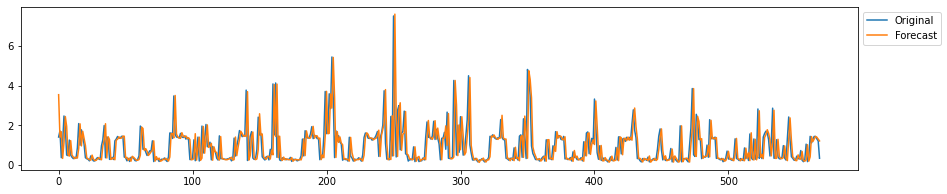

--------------------
training window 61452


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:34:56] getting statistics


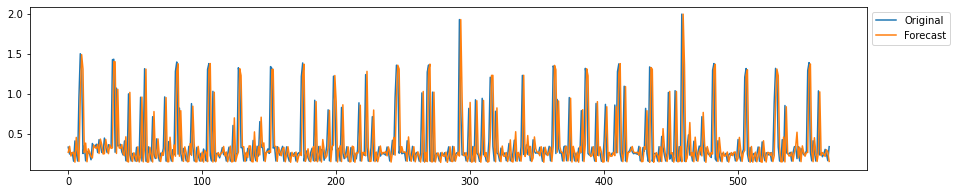

--------------------
training window 63728


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:35:19] getting statistics


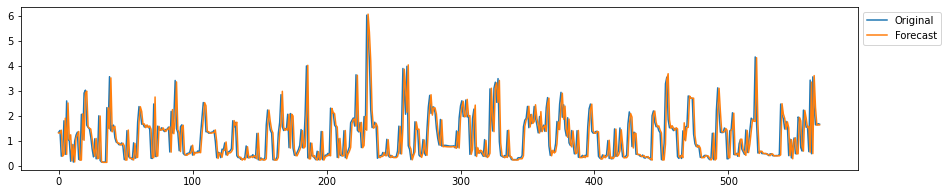

--------------------
training window 66004


/home/hugo/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 19:35:42] getting statistics


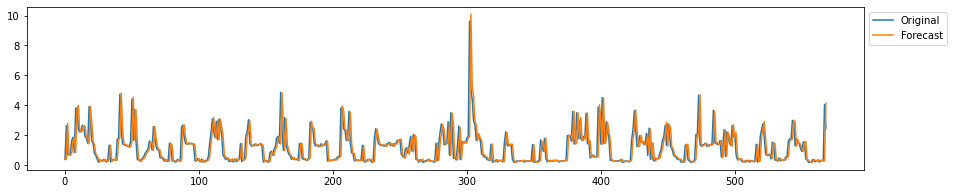

In [49]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": []
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data, windows_length, 0.75, inc=1):
    if len(ttest) > 0:

        data_train = ttrain.loc[:,'Global_active_power(t-1)':'Sub_metering_3(t-1)']
        data_test = ttest.loc[:,'Global_reactive_power(t-1)':'Global_active_power(t)']
        
        #ALtera o nome da columa porque o modelo utiliza esse label como variável endogena 
        data_test.rename(columns = {'Global_active_power(t)': 'Global_active_power(t-1)'}, inplace = True)
        
        start = len(data_train)
        end = len(data_train)+ len(data_test) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model, sarimax, pca_reduced_train = pca_sarimax.run_train_model(data_train)
        forecast, pca_reduced_test = pca_sarimax.run_test_model(data_test,sarimax,start,end)
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")
        rmse = Measures.rmse(pca_reduced_test['Global_active_power(t-1)'],forecast)
        mape = Measures.mape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        smape = Measures.smape(pca_reduced_test['Global_active_power(t-1)'],forecast)
        
#         forecast = pd.DataFrame(forecast)
#         forecast.fillna(forecast.mean(),inplace=True)
#         forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(pca_reduced_test['Global_active_power(t-1)'], forecast)
    
        # Grafico de comparação Original x Previsto para cada janela
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
        ax.plot(pca_reduced_test['Global_active_power(t-1)'], label='Original')
        ax.plot(forecast, label='Forecast')
        handles, labels = ax.get_legend_handles_labels()
        lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
        plt.show()
        
        
        result["rmse"].append(rmse)
        result["mae"].append(mae)
        result["mape"].append(mape)
        result["smape"].append(smape)
        result["window"].append(ct)
        
measures = pd.DataFrame(result)

In [53]:
measures

,window,rmse,mae,mape,smape
0,0,1.177025,0.719368,63.777761,22.529035
1,2276,1.101563,0.640230,56.357961,20.709612
2,4552,0.923186,0.539600,81.710026,27.371674
3,6828,0.849711,0.447462,90.971732,29.861093
4,9104,0.665585,0.313778,64.259411,21.089629
5,11380,0.975238,0.559796,74.520299,25.368612
6,13656,1.121405,0.638438,58.163245,20.837447
7,15932,1.078991,0.667114,51.408182,18.769868
8,18208,0.958120,0.557926,56.364772,20.908868
9,20484,1.006076,0.570646,59.959539,21.616164


In [54]:
### Mean Statistics PCA-SARIMAX

In [55]:
final_result = {
     "rmse": [],
     "mae":[],
     "mape": [],
     "smape": []
}

final_result["rmse"].append(statistics.mean(measures['rmse']))
final_result["mae"].append(statistics.mean(measures['mae']))
final_result["mape"].append(statistics.mean(measures['mape']))
final_result["smape"].append(statistics.mean(measures['smape']))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics PCA-SARIMAX (test): ")
final_measures_pca

Mean Statistics PCA-SARIMAX (test): 


,rmse,mae,mape,smape
0,0.901052,0.517548,64.931938,22.989602
